In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
import xgboost as xgb
import random
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

In [3]:
trainSet = pd.read_csv("data/train_set_NOT_UNDER_num_cat_no_null.csv")
trainSet.head()

,person,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,...,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,label
0,0008ed71,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0
1,000c79fe,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
2,001802e4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,0
3,0019e639,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0
4,001b0bf9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
trainSet.shape

(19414, 2503)

#### SubMuestreo o undersample

0    18434
1      980
Name: label, dtype: int64


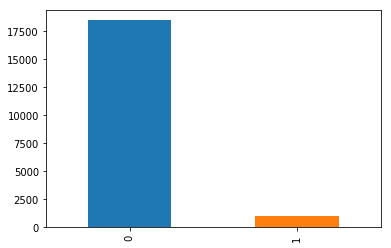

In [5]:
#Datos sin muestrear
import matplotlib.pyplot as plt
# graficos incrustados
%matplotlib inline
print trainSet['label'].value_counts()
trainSet['label'].value_counts().plot(kind= 'bar')

In [6]:
#1.Encuentra el número de muestras que son conversiones
# Genero una relacion 9 a 1 entre No-Conversiones y Conversiones
sizeConversiones = len(trainSet[trainSet['label'] == 1])*9 

In [7]:
#2. Obtener índices de muestras de no conversiones.
no_conversiones_indices = trainSet[trainSet.label == 0].index 

In [8]:
#Muestras aleatorias de índices de no conversiones.
#GENERO SEMILLA CON 3 PORQUE SI, EN REALIDAD PORQUE BRINDA UN NUMERO BAJO COMO 46
np.random.seed(3)
random_indices_no_conversiones = np.random.choice(no_conversiones_indices,sizeConversiones, replace=False)

In [9]:
#4. Encuentra los índices de muestras de conversiones.
conversiones = trainSet[trainSet.label == 1].index

In [10]:
#5. Índices de conversiones concat con muestras de no conversiones.
under_sample_indices = np.concatenate([conversiones,random_indices_no_conversiones])

In [11]:
#6 Obtener Balance Dataframe
under_sample = trainSet.loc[under_sample_indices]

In [12]:
under_sample = under_sample.sort_values(by='person')
under_sample['label'].value_counts()

0    8820
1     980
Name: label, dtype: int64

### Visualización de datos submuestreados

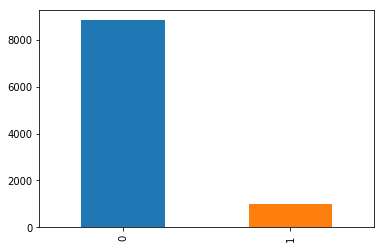

In [13]:
under_sample['label'].value_counts().plot(kind='bar')

Hiper-parámetros:

* **num_boost_round:** cantidad de árboles a contruir (n_estimators)
* **metrics:** la métrica de evaluación a utilizar

* **early_stopping_rounds:** terminar antes si la métrica no mejora luego de una cantidad de pasadas
* **seed:** semilla para poder reproducir los resultados

### COMIENZA LA BUSQUEDA DE PARAMETROS

In [14]:
trainSet.shape

(19414, 2503)

In [15]:
under_sample.shape

(9800, 2503)

In [16]:
target = 'label'
IDcol = 'person'

#Choose all predictors except target & IDcols
train = under_sample
predictors = [x for x in train.columns if x not in [target, IDcol]]

In [17]:
testSet = pd.read_csv("data/test_set_num_cat_no_null.csv").drop(columns = "Unnamed: 0")
print testSet.shape
testSet.head()

(19415, 2502)


,person,Enero_cantEventos,Enero_checkouts,Enero_leads,Enero_conversiones,Enero_staticPageVisitadas,Enero_ProductosVistosPorUser,Enero_productosBuscados,Enero_accesos por marketing online,Enero_searchEngine,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,00091926,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.0
1,00091a7a,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000ba417,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
3,000e4d9e,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
4,000e619d,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


In [18]:
train.head()

,person,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,...,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,label
0,0008ed71,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0
1,000c79fe,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
6,001dfc31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
7,001e9aea,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.5,0.5,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
9,002b0188,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0


In [19]:
#VERIFICAMOS QUE LOS NOMBRES SON LOS MISMO, PERO EN DIFERENTE FORMATO. PROCEDEMOS A NORMALIZARLOS.
#prueba= train.columns.drop('label')
testSet.columns=train.columns.drop('label')
testSet.head()

,person,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,00091926,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.0
1,00091a7a,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000ba417,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
3,000e4d9e,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
4,000e619d,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


### FUNCIONES UTILIZADAS

In [20]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=30):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)

    

In [21]:
def modelfit2(alg, dtrain, predictors,dtest,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)
    
    #GRAFICO DE CURVA AUR-ROC PARA MOST-IMPORTANT
    #SOLO SE DEBE REEMPLAZAR LOS LABELS Y LAS PREDICCIONES EN roc_curve

    fpr, tpr, threshold = roc_curve(dtrain['label'].values, dtrain_predprob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(20,10))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of XGBOOST')
    plt.show()
    
    return dtest_predprob

### GENERAMOS UN MODELO CON DATOS COLOCADOS "A OJO"

In [79]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=50,
 max_depth=3,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.35,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 seed=1024)


Model Report
Accuracy : 0.8127
AUC Score (Train): 0.861511


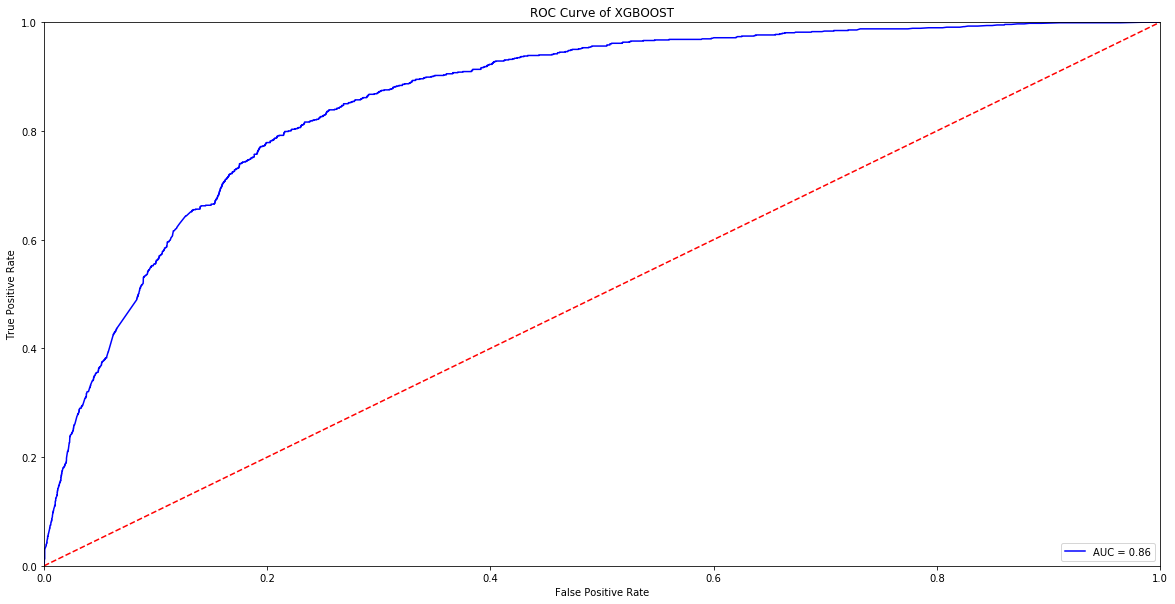

In [80]:
#GENERAMOS EL ARCHIVO CON PARAMETROS COLOCADOS A "OJO"
predict_base=modelfit2(xgb1, train, predictors,testSet)

In [81]:
df_base=pd.DataFrame({'person':testSet['person']})
df_base['label']=predict_base
df_base.head()

,person,label
0,00091926,0.420333
1,00091a7a,0.618111
2,000ba417,0.497317
3,000e4d9e,0.459961
4,000e619d,0.476844


In [82]:
df_base.to_csv('submit_kaggle/sub20_base_modelo3_xGBoost_9a1.csv', index=False)

### COMENZAMOS CON EL TUNING DE LOS PARAMETROS

In [35]:
#SITUACION INICIAL
param_test0 = {
 'n_estimators':[800],#range(50, 400, 50),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=800, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84868, std: 0.00630, params: {'n_estimators': 800}],
 {'n_estimators': 800},
 0.8486842866398259)

In [36]:
#BUSCAMOS CUANTOS ARBOLES GENERAR PARA LAS PRUEBAS
param_test0 = {
 'n_estimators':range(100, 1000, 100),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=800, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84373, std: 0.00873, params: {'n_estimators': 100},
  mean: 0.84840, std: 0.00822, params: {'n_estimators': 200},
  mean: 0.85060, std: 0.00809, params: {'n_estimators': 300},
  mean: 0.85139, std: 0.00771, params: {'n_estimators': 400},
  mean: 0.85118, std: 0.00707, params: {'n_estimators': 500},
  mean: 0.85063, std: 0.00666, params: {'n_estimators': 600},
  mean: 0.84982, std: 0.00643, params: {'n_estimators': 700},
  mean: 0.84868, std: 0.00630, params: {'n_estimators': 800},
  mean: 0.84764, std: 0.00609, params: {'n_estimators': 900}],
 {'n_estimators': 400},
 0.8513857073441622)

In [37]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':range(2,10,2),
 'min_child_weight':range(1,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85000, std: 0.00821, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.85013, std: 0.00822, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.85025, std: 0.00805, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.85040, std: 0.00815, params: {'max_depth': 2, 'min_child_weight': 7},
  mean: 0.85042, std: 0.00822, params: {'max_depth': 2, 'min_child_weight': 9},
  mean: 0.84786, std: 0.00854, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.84934, std: 0.00807, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.85001, std: 0.00798, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.85038, std: 0.00780, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: 0.85068, std: 0.00783, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: 0.84267, std: 0.00960, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.84453, std: 0.00941, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.84599, std: 0.00909, params: {

In [38]:
# SE ENCUENTRAN LOS PARAMETROS ADECUADOS PARA max_depth Y min_child_weight
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[7,8,9]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85139, std: 0.00771, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.85156, std: 0.00763, params: {'max_depth': 3, 'min_child_weight': 8},
  mean: 0.85185, std: 0.00755, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: 0.85038, std: 0.00780, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: 0.85056, std: 0.00782, params: {'max_depth': 4, 'min_child_weight': 8},
  mean: 0.85068, std: 0.00783, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: 0.84878, std: 0.00868, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.84921, std: 0.00861, params: {'max_depth': 5, 'min_child_weight': 8},
  mean: 0.84931, std: 0.00819, params: {'max_depth': 5, 'min_child_weight': 9}],
 {'max_depth': 3, 'min_child_weight': 9},
 0.8518493451802488)

In [39]:
# SE HALLA EL PARAMETRO ADECUADO PARA gamma
param_test3 = {
 'gamma':[0,0.1,0.2,0.3,0.4,0.5]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85185, std: 0.00755, params: {'gamma': 0},
  mean: 0.85185, std: 0.00755, params: {'gamma': 0.1},
  mean: 0.85185, std: 0.00755, params: {'gamma': 0.2},
  mean: 0.85186, std: 0.00755, params: {'gamma': 0.3},
  mean: 0.85186, std: 0.00755, params: {'gamma': 0.4},
  mean: 0.85186, std: 0.00755, params: {'gamma': 0.5}],
 {'gamma': 0.3},
 0.8518551298070248)

In [40]:
# SE COMIENZA CON LA BUSQUEDA DE subsample Y colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=9, gamma=0.3, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85098, std: 0.00829, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.85078, std: 0.00841, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.85035, std: 0.00804, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.84963, std: 0.00817, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.85072, std: 0.00803, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.85047, std: 0.00803, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.85072, std: 0.00792, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.84944, std: 0.00831, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.85040, std: 0.00811, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.85046, std: 0.00780, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.84997, std: 0.00748, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.84896, std: 0.00779, params: {'subsample': 0.9, 'colsample_bytree'

In [43]:
# FINALMENTE SE ENCUENTRAN LOS PARMETROS ADECUADOS PARA subsample Y colsample_bytree
param_test5b = {
 'colsample_bytree':[0.1,0.2,0.3,0.4,0.5],
 'subsample':[0.9]
}
gsearch5b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=9, gamma=0.3, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test5b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5b.fit(train[predictors],train[target])
gsearch5b.grid_scores_, gsearch5b.best_params_, gsearch5b.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85209, std: 0.00785, params: {'subsample': 0.9, 'colsample_bytree': 0.1},
  mean: 0.85183, std: 0.00795, params: {'subsample': 0.9, 'colsample_bytree': 0.2},
  mean: 0.85173, std: 0.00841, params: {'subsample': 0.9, 'colsample_bytree': 0.3},
  mean: 0.85123, std: 0.00813, params: {'subsample': 0.9, 'colsample_bytree': 0.4},
  mean: 0.85029, std: 0.00831, params: {'subsample': 0.9, 'colsample_bytree': 0.5}],
 {'colsample_bytree': 0.1, 'subsample': 0.9},
 0.8520876718034153)

In [44]:
# FINALMENTE SE ENCUENTRAN LOS PARMETROS ADECUADOS PARA subsample Y colsample_bytree
param_test5 = {
 'colsample_bytree':[0.1,0.2,0.3,0.4,0.5],
 'subsample':[0.8]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=9, gamma=0.3, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85149, std: 0.00729, params: {'subsample': 0.8, 'colsample_bytree': 0.1},
  mean: 0.85198, std: 0.00831, params: {'subsample': 0.8, 'colsample_bytree': 0.2},
  mean: 0.85186, std: 0.00755, params: {'subsample': 0.8, 'colsample_bytree': 0.3},
  mean: 0.85152, std: 0.00805, params: {'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: 0.85118, std: 0.00763, params: {'subsample': 0.8, 'colsample_bytree': 0.5}],
 {'colsample_bytree': 0.2, 'subsample': 0.8},
 0.8519806562080614)

In [90]:
# SE REALIZA LA BUSQUEDA DE reg_alpha
param_test6 = {
 'reg_alpha':[0,1e-5,1e-4,1e-3,1e-2]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=9, gamma=0.3, subsample=0.9, colsample_bytree=0.1, reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.84813, std: 0.00693, params: {'reg_alpha': 0},
  mean: 0.84813, std: 0.00693, params: {'reg_alpha': 1e-05},
  mean: 0.84813, std: 0.00693, params: {'reg_alpha': 0.0001},
  mean: 0.84813, std: 0.00693, params: {'reg_alpha': 0.001},
  mean: 0.84805, std: 0.00687, params: {'reg_alpha': 0.01}],
 {'reg_alpha': 0},
 0.8481275163126476)

### POR ULTIMO BUSCAMOS LOS VALORES FINALES PARA n_estimators Y learning_rate

In [91]:
param_test0 = {
 'n_estimators':[700],
 'learning_rate':[0.0001]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.83998, std: 0.00916, params: {'n_estimators': 700, 'learning_rate': 0.0001}],
 {'learning_rate': 0.0001, 'n_estimators': 700},
 0.8399836295062242)

In [93]:
param_test0 = {
 'n_estimators':[1000],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84634, std: 0.00575, params: {'n_estimators': 1000, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 1000},
 0.8463374635568514)

In [94]:
param_test0 = {
 'n_estimators':[800],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84868, std: 0.00630, params: {'n_estimators': 800, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 800},
 0.8486842866398259)

In [95]:
param_test0 = {
 'n_estimators':[850],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84819, std: 0.00609, params: {'n_estimators': 850, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 850},
 0.8481879656624555)

In [96]:
param_test0 = {
 'n_estimators':[825],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84852, std: 0.00618, params: {'n_estimators': 825, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 825},
 0.848517110926003)

# FINALMENTE VERIFICAMOS LOS PARAMETROS OBTENIDOS

In [97]:
# PARAMETROS INICIAL
param_test0 = {
 'n_estimators':[50],
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=50, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84487, std: 0.00803, params: {'n_estimators': 50}],
 {'n_estimators': 50},
 0.8448652760423897)

In [100]:
#PARAMETROS CON TUNING1
param_test0 = {
 'n_estimators':[100],
 'learning_rate':[0.05]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84813, std: 0.00693, params: {'n_estimators': 100, 'learning_rate': 0.05}],
 {'learning_rate': 0.05, 'n_estimators': 100},
 0.8481275163126476)

In [99]:
#PARAMETROS CON TUNING
param_test0 = {
 'n_estimators':[800],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84868, std: 0.00630, params: {'n_estimators': 800, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 800},
 0.8486842866398259)


Model Report
Accuracy : 0.8267
AUC Score (Train): 0.884061


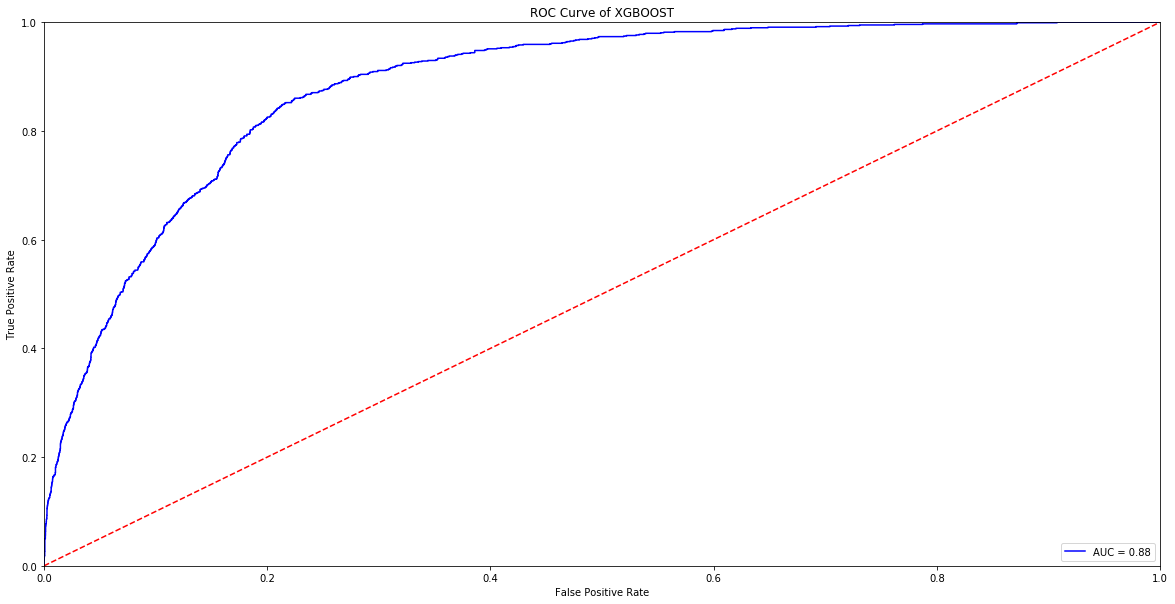

array([0.2476794 , 0.69317055, 0.41440588, ..., 0.5954293 , 0.5814856 ,
       0.1496526 ], dtype=float32)

In [103]:
# COMO HEMOS TENIDO UN RESULTADO SE GENERO UNA MAYOR CANTIDAD DE ARBOLES Y SE ENTRENO EL NUEVO MODELO
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=3,
 min_child_weight=7,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=6, #2940/980=3
 reg_alpha= 0.011,
 seed=1024)
modelfit2(xgb2, train, predictors,testSet)

# FINALMENTE CON EL MEJOR MODELO REALIZAMOS LAS PREDICCIONES

In [104]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=3,
 min_child_weight=7,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 reg_alpha= 0.011,
 seed=1024)


Model Report
Accuracy : 0.8036
AUC Score (Train): 0.885007


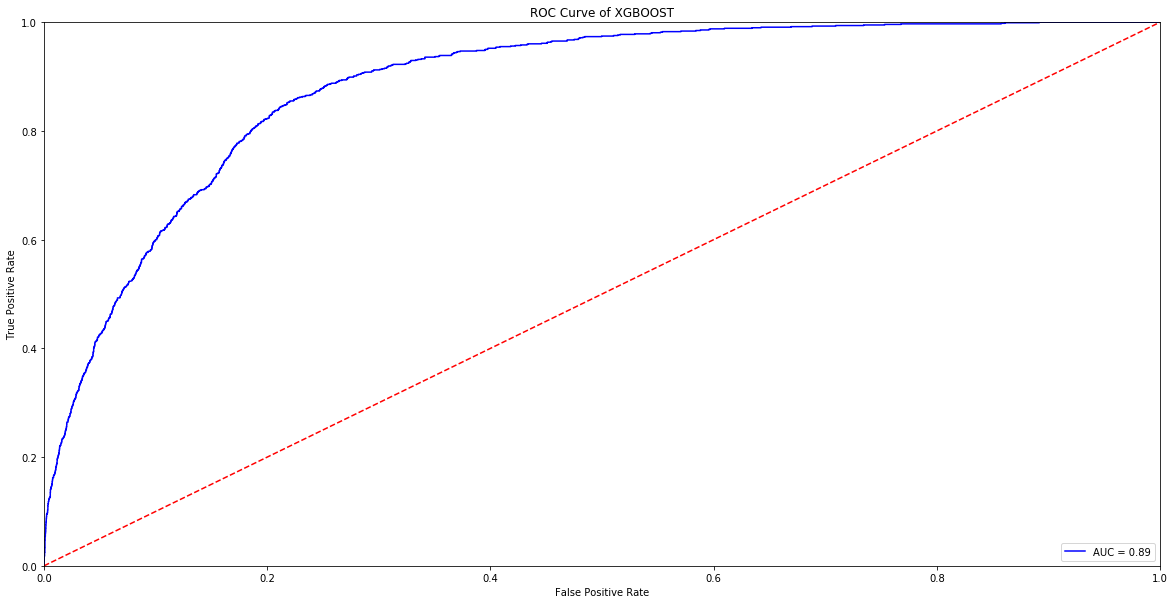

In [105]:
predict_test_tuning=modelfit2(xgb2, train, predictors,testSet)

In [106]:

df_prueba_tuning=pd.DataFrame({'person':testSet['person']})
df_prueba_tuning['label']=predict_test_tuning
df_prueba_tuning.head()


,person,label
0,00091926,0.333588
1,00091a7a,0.772526
2,000ba417,0.520818
3,000e4d9e,0.434658
4,000e619d,0.512722


In [107]:
df_prueba_tuning.to_csv('submit_kaggle/sub20_modelo3_xGBoost_tuning_9a1.csv', index=False)

# INTENTAREMOS MEJORAR NUESTRA PREDICIONES TRABAJANDO AUN MAS CON LOS DATOS, ESTANDARIZAMOS LOS MISMOS.

### ESTANDARIZO LAS MATRICES

In [22]:
features=train.iloc[:,1:]
features=features.iloc[:,:-1]
feature_list = list(features.columns)
print features.shape
features.head()

(9800, 2501)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.5,-0.5,0.5,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


In [23]:
#NORMALIZO EL DF Y VERIFICO QUE NO HAYA NaN

# Get column names first
names = features.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()#MinMaxScaler()#Normalizer()#StandardScaler()

# Fit your data on the scaler object
scaled_df = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_df, columns=names)
print scaled_df.shape
features=scaled_df
features_under_sample_std=scaled_df
print ("Hay Null: ",features.isnull().values.any())
scaled_df.head()

(9800, 2501)
('Hay Null: ', False)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-2.447121,-2.426629,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530
1,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.481011,0.484382,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
2,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.481011,0.484382,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
3,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.983055,-0.971123,-0.242913,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
4,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-2.447121,-2.426629,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530


In [24]:
train_scaled_person=pd.DataFrame({'person':train['person']}).reset_index().drop('index',1)
train_scaled_person.head()

,person
0,0008ed71
1,000c79fe
2,001dfc31
3,001e9aea
4,002b0188


In [25]:
train_scaled_label=pd.DataFrame({'label':train['label']}).reset_index().drop('index',1)
train_scaled_label.head()

,label
0,0
1,0
2,0
3,0
4,0


In [26]:
train_scaled=scaled_df.loc[:,:]
train_scaled['person']=train_scaled_person['person']
train_scaled['label']=train_scaled_label['label']
train_scaled.head(15)

,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,person,label
0,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,0008ed71,0
1,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,000c79fe,0
2,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,001dfc31,0
3,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.242913,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,001e9aea,0
4,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,002b0188,0
5,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,2.998771,-0.056716,2.831697,0.262177,0.883097,-0.908229,-0.880242,-1.021258,003476c0,1
6,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,003847fc,0
7,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,003a7d49,0
8,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,003bdb4d,0
9,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.891250,-0.056716,-0.376321,-3.727479,0.883097,-0.908229,-0.880242,0.985530,003d4cac,1


In [27]:
features_test=testSet.iloc[:,1:]
feature_list = list(features_test.columns)
print features_test.shape
features_test.head()

(19415, 2501)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


In [28]:
#NORMALIZO EL DF Y VERIFICO QUE NO HAYA NaN

# Get column names first
names = features_test.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()#MinMaxScaler()#Normalizer()#StandardScaler()

# Fit your data on the scaler object
scaled_df = scaler.fit_transform(features_test)
scaled_df = pd.DataFrame(scaled_df, columns=names)
print scaled_df.shape
features_test=scaled_df
print ("Hay Null: ",features_test.isnull().values.any())
scaled_df.head()

(19415, 2501)
('Hay Null: ', False)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,3.011501,-0.057554,2.780762,0.249683,-1.020763,1.128591,1.159879,0.991185
1,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,-0.906760,-0.057554,-0.383098,-3.802864,0.885495,-0.909337,-0.884952,0.991185
2,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185
3,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185
4,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185


In [29]:
scaled_df['person']=testSet['person']
test_scaled=scaled_df.loc[:,:]
test_scaled.head()

,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,person
0,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,3.011501,-0.057554,2.780762,0.249683,-1.020763,1.128591,1.159879,0.991185,00091926
1,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,-0.906760,-0.057554,-0.383098,-3.802864,0.885495,-0.909337,-0.884952,0.991185,00091a7a
2,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185,000ba417
3,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185,000e4d9e
4,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185,000e619d


# FINALMENTE CON LOS VALORES DE LOS HIPERPARAMETROS OBTENIDOS CONSTRUIMOS EL MODELO

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8055
AUC Score (Train): 0.881939


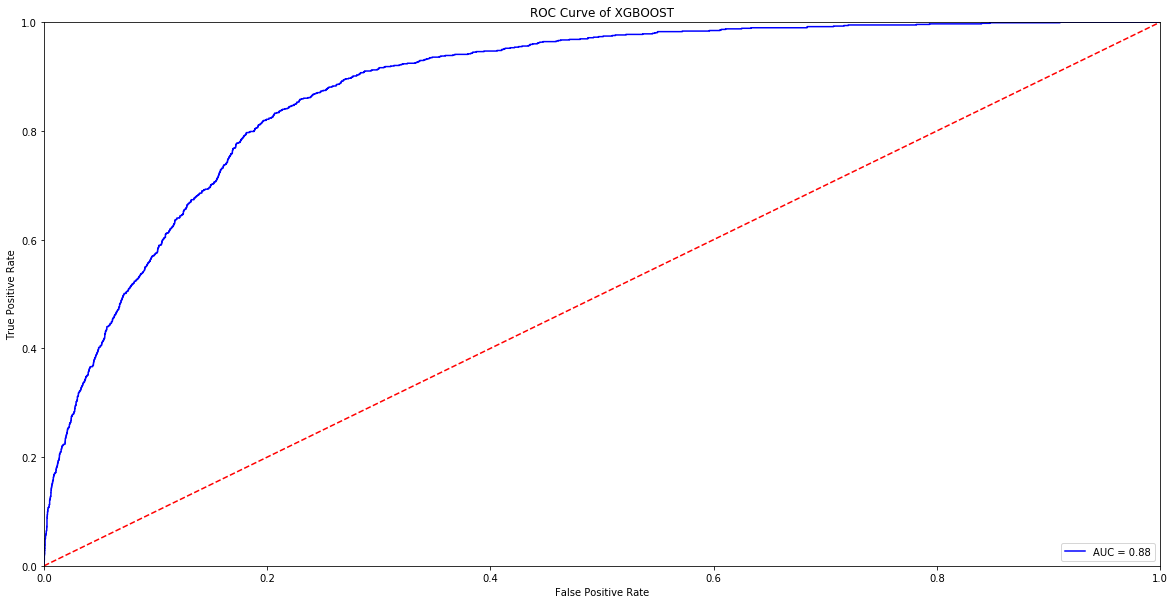

In [49]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=3,
 min_child_weight=9,
 gamma=0.3,
 subsample=0.9,
 colsample_bytree=0.1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 reg_alpha= 0,
 seed=1024)
predict_test_final_std=modelfit2(xgb2, train_scaled, predictors,test_scaled)

In [50]:
df_test_final_std=pd.DataFrame({'person':testSet['person']})
df_test_final_std['label']=predict_test_final_std
df_test_final_std.head(25)


,person,label
0,00091926,0.302830
1,00091a7a,0.768373
2,000ba417,0.513406
3,000e4d9e,0.388057
4,000e619d,0.468010
5,001001be,0.295899
6,0010e89a,0.100194
7,0016c4b5,0.078476
8,001804a2,0.240697
9,001a2273,0.093514


In [47]:
#VERIFICAMOS PREDICCIONES FINALES STD
np.around(df_test_final_std['label']).value_counts()

0.0    14815
1.0     4600
Name: label, dtype: int64

In [51]:
#VERIFICAMOS PREDICCIONES FINALES STD
np.around(df_test_final_std['label']).value_counts()

0.0    14821
1.0     4594
Name: label, dtype: int64

In [52]:
#NOS QUEDAMOS CON EL MODELO STANDARIZADO
df_test_final_std.to_csv('submit_kaggle/re-tuning-2-sub_modelo3_xGBoost_9a1_std.csv', index=False)

In [53]:
df_test_final_std.sort_values(by='person')

,person,label
0,00091926,0.302830
1,00091a7a,0.768373
2,000ba417,0.513406
3,000e4d9e,0.388057
4,000e619d,0.468010
5,001001be,0.295899
6,0010e89a,0.100194
7,0016c4b5,0.078476
8,001804a2,0.240697
9,001a2273,0.093514


In [76]:
fi=xgb2.feature_importances_
print -np.sort(-fi)

[0.02240999 0.02204262 0.02094048 ... 0.         0.         0.        ]


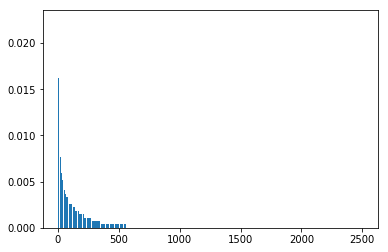

In [77]:
# plot
plt.bar(range(len(xgb2.feature_importances_)), -np.sort(-fi))
plt.show()

In [95]:
(xgb2.feature_importances_>xgb2.feature_importances_.mean()).sum()

357

In [64]:
train_scaled_not_person_label=train_scaled.iloc[:,:-2]
train_scaled_not_person_label.head()

,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-2.447121,-2.426629,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530
1,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.481011,0.484382,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
2,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.481011,0.484382,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
3,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.983055,-0.971123,-0.242913,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
4,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-2.447121,-2.426629,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530


In [94]:
reduced_features=train_scaled_not_person_label.loc[:,(xgb2.feature_importances_>xgb2.feature_importances_.mean())]
reduced_features['person']=train_scaled_person['person']
reduced_features['label']=train_scaled_label['label']
reduced_features.head()

,F13_color_fh45-Enero,F13_condition_fh5-Enero.2,F13_model_fh39-Enero,F13_model_fh59-Enero,F13_model_fh7-Enero,F13_model_fh77-Enero,F13_device_type_fh4-Enero,F13_color_fh33-Febrero,F13_color_fh47-Febrero.1,F13_screen_resolution_fh161-Febrero,...,F13_region_fh45-Mayo,F13_region_fh64-Mayo,F13_region_fh74-Mayo,F13_region_fh82-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,person,label
0,-0.111464,-0.155263,-0.131279,-0.120836,0.127005,-0.157249,-0.124978,-0.145271,-0.089972,-0.191058,...,0.285775,-0.126930,0.734528,-2.426629,-1.021443,1.127955,1.164207,0.985530,0008ed71,0
1,-0.111464,-0.155263,-0.131279,-0.120836,0.127005,-0.157249,-0.124978,-0.145271,-0.089972,-0.191058,...,0.285775,-1.252314,0.734528,0.484382,0.883097,-0.908229,-0.880242,-1.021258,000c79fe,0
2,-0.111464,-0.155263,-0.131279,-0.120836,0.127005,-0.157249,-0.124978,11.826688,-0.089972,4.550655,...,0.285775,0.998455,-1.447443,0.484382,0.883097,-0.908229,-0.880242,-1.021258,001dfc31,0
3,-0.111464,-0.155263,-0.131279,-0.120836,0.127005,-0.157249,-0.124978,-0.145271,-0.089972,-0.191058,...,0.285775,0.435763,-0.356458,-0.971123,0.883097,-0.908229,-0.880242,-1.021258,001e9aea,0
4,-0.111464,-0.155263,-0.131279,-0.120836,0.127005,-0.157249,-0.124978,-0.145271,-0.089972,-0.191058,...,0.285775,-0.126930,0.734528,-2.426629,-1.021443,1.127955,1.164207,0.985530,002b0188,0


In [96]:
reduced_testSet=test_scaled.loc[:,(xgb2.feature_importances_>xgb2.feature_importances_.mean())]
reduced_testSet.head()

,F13_color_fh45-Enero,F13_condition_fh5-Enero.2,F13_model_fh39-Enero,F13_model_fh59-Enero,F13_model_fh7-Enero,F13_model_fh77-Enero,F13_device_type_fh4-Enero,F13_color_fh33-Febrero,F13_color_fh47-Febrero.1,F13_screen_resolution_fh161-Febrero,...,F13_region_fh40-Mayo,F13_region_fh41-Mayo,F13_region_fh45-Mayo,F13_region_fh64-Mayo,F13_region_fh74-Mayo,F13_region_fh82-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,-0.104447,-0.154252,-0.134169,-0.121361,0.127506,-0.156159,-0.12613,-0.147147,-0.08641,-0.191894,...,0.885730,-0.425900,0.292908,1.010443,-1.457481,0.48047,-1.020763,1.128591,1.159879,0.991185
1,-0.104447,-0.154252,-0.134169,-0.121361,0.127506,-0.156159,-0.12613,-0.147147,-0.08641,-0.191894,...,-0.602481,-1.463004,0.292908,-1.243874,0.726481,0.48047,0.885495,-0.909337,-0.884952,0.991185
2,-0.104447,-0.154252,-0.134169,-0.121361,0.127506,-0.156159,-0.12613,-0.147147,-0.08641,-0.191894,...,-0.602481,0.611204,0.292908,1.010443,-1.457481,0.48047,-1.020763,1.128591,1.159879,0.991185
3,-0.104447,-0.154252,-0.134169,-0.121361,0.127506,-0.156159,-0.12613,-0.147147,-0.08641,-0.191894,...,0.885730,0.611204,0.292908,-1.243874,0.726481,0.48047,-1.020763,1.128591,1.159879,0.991185
4,-0.104447,-0.154252,-0.134169,-0.121361,0.127506,-0.156159,-0.12613,-0.147147,-0.08641,-0.191894,...,-0.602481,0.611204,0.292908,1.010443,-1.457481,0.48047,-1.020763,1.128591,1.159879,0.991185


In [105]:
#NOS QUEDAMOS CON EL MODELO STANDARIZADO
reduced_features.to_csv('data/reduced_features.csv', index=False)
reduced_testSet.to_csv('data/reduced_testSet.csv', index=False)

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8043
AUC Score (Train): 0.884869


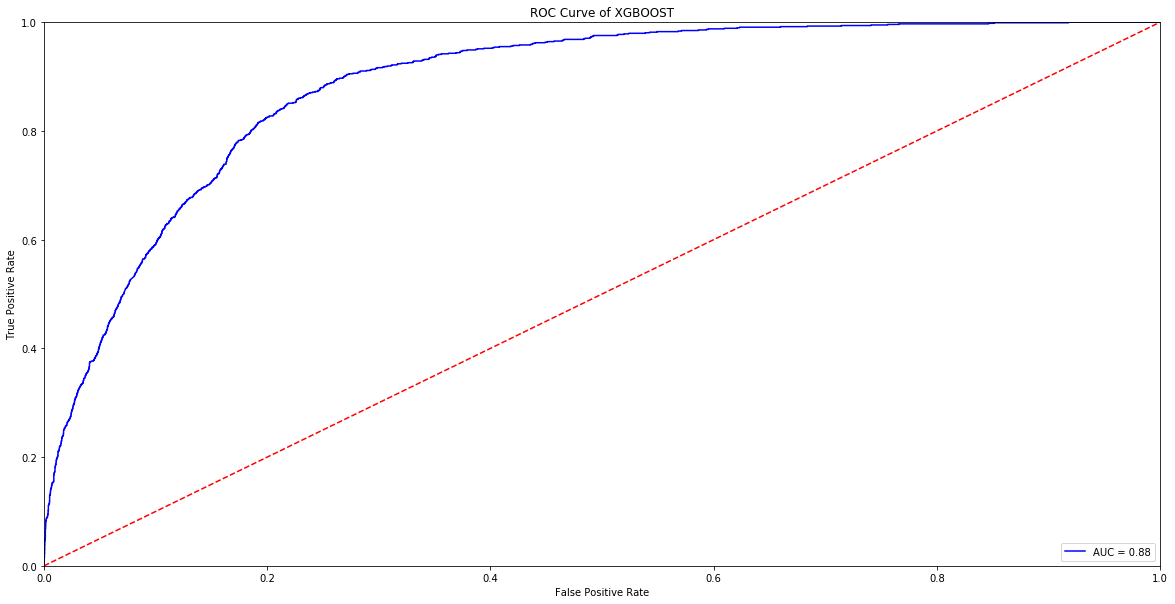

In [130]:
reduced_predictors= [x for x in reduced_features.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=3,
 min_child_weight=7,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 reg_alpha= 0.011,
 seed=1024)
predict_test_reduced=modelfit2(xgb2, reduced_features, reduced_predictors,reduced_testSet)

In [100]:
df_test_final_std_reduced=pd.DataFrame({'person':testSet['person']})
df_test_final_std_reduced['label']=predict_test_reduced
df_test_final_std_reduced.head(25)

,person,label
0,00091926,0.332737
1,00091a7a,0.775429
2,000ba417,0.507741
3,000e4d9e,0.424637
4,000e619d,0.487730
5,001001be,0.269965
6,0010e89a,0.099653
7,0016c4b5,0.076769
8,001804a2,0.252185
9,001a2273,0.091326


In [101]:
#VERIFICAMOS PREDICCIONES FINALES STD
np.around(df_test_final_std_reduced['label']).value_counts()

0.0    14774
1.0     4641
Name: label, dtype: int64

In [102]:
#NOS QUEDAMOS CON EL MODELO STANDARIZADO
df_test_final_std_reduced.to_csv('submit_kaggle/tuning-features_reduced-sub_modelo3_xGBoost_9a1_std.csv', index=False)

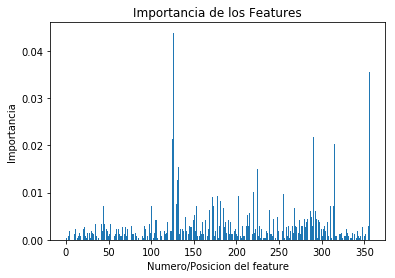

In [131]:
# plot
plt.title('Importancia de los Features')
plt.xlabel('Numero/Posicion del feature')
plt.ylabel('Importancia')
plt.bar(range(len(xgb2.feature_importances_)), xgb2.feature_importances_)
plt.show()

In [106]:
#SITUACION INICIAL
param_test0 = {
 'n_estimators':[800],#range(50, 400, 50),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=800, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_
#reduced_features, reduced_predictors,reduced_testSet)

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85198, std: 0.00673, params: {'n_estimators': 800}],
 {'n_estimators': 800},
 0.8519766069693183)

In [107]:
#SITUACION INICIAL
param_test0 = {
 'n_estimators':range(400, 4400, 400),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=800, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85293, std: 0.00741, params: {'n_estimators': 400},
  mean: 0.85198, std: 0.00673, params: {'n_estimators': 800},
  mean: 0.84951, std: 0.00586, params: {'n_estimators': 1200},
  mean: 0.84742, std: 0.00609, params: {'n_estimators': 1600},
  mean: 0.84545, std: 0.00590, params: {'n_estimators': 2000},
  mean: 0.84330, std: 0.00571, params: {'n_estimators': 2400},
  mean: 0.84095, std: 0.00585, params: {'n_estimators': 2800},
  mean: 0.83959, std: 0.00623, params: {'n_estimators': 3200},
  mean: 0.83771, std: 0.00632, params: {'n_estimators': 3600},
  mean: 0.83635, std: 0.00618, params: {'n_estimators': 4000}],
 {'n_estimators': 400},
 0.8529319380813549)

In [109]:
from xgboost import plot_tree
#plot_tree(xgb2)


In [110]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':range(2,10,2),
 'min_child_weight':range(1,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85110, std: 0.00830, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.85116, std: 0.00825, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.85131, std: 0.00826, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.85144, std: 0.00832, params: {'max_depth': 2, 'min_child_weight': 7},
  mean: 0.85143, std: 0.00832, params: {'max_depth': 2, 'min_child_weight': 9},
  mean: 0.85163, std: 0.00770, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.85204, std: 0.00811, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.85237, std: 0.00815, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.85288, std: 0.00800, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: 0.85313, std: 0.00815, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: 0.84698, std: 0.00763, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.84782, std: 0.00754, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.84932, std: 0.00771, params: {

In [111]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':[3,4,5],
 'min_child_weight':[8,9,10]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85311, std: 0.00756, params: {'max_depth': 3, 'min_child_weight': 8},
  mean: 0.85320, std: 0.00758, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: 0.85347, std: 0.00759, params: {'max_depth': 3, 'min_child_weight': 10},
  mean: 0.85312, std: 0.00809, params: {'max_depth': 4, 'min_child_weight': 8},
  mean: 0.85313, std: 0.00815, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: 0.85310, std: 0.00796, params: {'max_depth': 4, 'min_child_weight': 10},
  mean: 0.85207, std: 0.00736, params: {'max_depth': 5, 'min_child_weight': 8},
  mean: 0.85210, std: 0.00745, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: 0.85211, std: 0.00746, params: {'max_depth': 5, 'min_child_weight': 10}],
 {'max_depth': 3, 'min_child_weight': 10},
 0.8534701976028506)

In [112]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':[3],
 'min_child_weight':[10,11,12,13,14]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85347, std: 0.00759, params: {'max_depth': 3, 'min_child_weight': 10},
  mean: 0.85335, std: 0.00741, params: {'max_depth': 3, 'min_child_weight': 11},
  mean: 0.85352, std: 0.00748, params: {'max_depth': 3, 'min_child_weight': 12},
  mean: 0.85363, std: 0.00754, params: {'max_depth': 3, 'min_child_weight': 13},
  mean: 0.85369, std: 0.00742, params: {'max_depth': 3, 'min_child_weight': 14}],
 {'max_depth': 3, 'min_child_weight': 14},
 0.8536929057337221)

In [113]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':[3],
 'min_child_weight':[14,20,30,40,50,60]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85369, std: 0.00742, params: {'max_depth': 3, 'min_child_weight': 14},
  mean: 0.85365, std: 0.00799, params: {'max_depth': 3, 'min_child_weight': 20},
  mean: 0.85404, std: 0.00806, params: {'max_depth': 3, 'min_child_weight': 30},
  mean: 0.85382, std: 0.00843, params: {'max_depth': 3, 'min_child_weight': 40},
  mean: 0.85319, std: 0.00853, params: {'max_depth': 3, 'min_child_weight': 50},
  mean: 0.85252, std: 0.00902, params: {'max_depth': 3, 'min_child_weight': 60}],
 {'max_depth': 3, 'min_child_weight': 30},
 0.8540399833402749)

In [115]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':[3],
 'min_child_weight':[30,31,32,33,34,35,36,37,38,39]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85404, std: 0.00806, params: {'max_depth': 3, 'min_child_weight': 30},
  mean: 0.85389, std: 0.00801, params: {'max_depth': 3, 'min_child_weight': 31},
  mean: 0.85389, std: 0.00808, params: {'max_depth': 3, 'min_child_weight': 32},
  mean: 0.85391, std: 0.00833, params: {'max_depth': 3, 'min_child_weight': 33},
  mean: 0.85397, std: 0.00819, params: {'max_depth': 3, 'min_child_weight': 34},
  mean: 0.85397, std: 0.00826, params: {'max_depth': 3, 'min_child_weight': 35},
  mean: 0.85398, std: 0.00839, params: {'max_depth': 3, 'min_child_weight': 36},
  mean: 0.85387, std: 0.00836, params: {'max_depth': 3, 'min_child_weight': 37},
  mean: 0.85385, std: 0.00830, params: {'max_depth': 3, 'min_child_weight': 38},
  mean: 0.85387, std: 0.00846, params: {'max_depth': 3, 'min_child_weight': 39}],
 {'max_depth': 3, 'min_child_weight': 30},
 0.8540399833402749)

In [116]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':[3],
 'min_child_weight':[21,22,23,24,25,26,27,28,29,30]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85373, std: 0.00789, params: {'max_depth': 3, 'min_child_weight': 21},
  mean: 0.85385, std: 0.00801, params: {'max_depth': 3, 'min_child_weight': 22},
  mean: 0.85378, std: 0.00797, params: {'max_depth': 3, 'min_child_weight': 23},
  mean: 0.85388, std: 0.00793, params: {'max_depth': 3, 'min_child_weight': 24},
  mean: 0.85371, std: 0.00803, params: {'max_depth': 3, 'min_child_weight': 25},
  mean: 0.85379, std: 0.00794, params: {'max_depth': 3, 'min_child_weight': 26},
  mean: 0.85366, std: 0.00806, params: {'max_depth': 3, 'min_child_weight': 27},
  mean: 0.85394, std: 0.00795, params: {'max_depth': 3, 'min_child_weight': 28},
  mean: 0.85395, std: 0.00814, params: {'max_depth': 3, 'min_child_weight': 29},
  mean: 0.85404, std: 0.00806, params: {'max_depth': 3, 'min_child_weight': 30}],
 {'max_depth': 3, 'min_child_weight': 30},
 0.8540399833402749)

In [118]:
# SE HALLA EL PARAMETRO ADECUADO PARA gamma
param_test3 = {
 'gamma':[0,0.1,0.2,0.3,0.4,0.5]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=30, gamma=0, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85404, std: 0.00806, params: {'gamma': 0},
  mean: 0.85404, std: 0.00806, params: {'gamma': 0.1},
  mean: 0.85404, std: 0.00806, params: {'gamma': 0.2},
  mean: 0.85404, std: 0.00806, params: {'gamma': 0.3},
  mean: 0.85404, std: 0.00806, params: {'gamma': 0.4},
  mean: 0.85404, std: 0.00806, params: {'gamma': 0.5}],
 {'gamma': 0.1},
 0.8540417187283076)

In [119]:
# SE COMIENZA CON LA BUSQUEDA DE subsample Y colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(2,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=30, gamma=0.1, subsample=0.8, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85357, std: 0.00844, params: {'subsample': 0.6, 'colsample_bytree': 0.2},
  mean: 0.85302, std: 0.00777, params: {'subsample': 0.7, 'colsample_bytree': 0.2},
  mean: 0.85379, std: 0.00818, params: {'subsample': 0.8, 'colsample_bytree': 0.2},
  mean: 0.85422, std: 0.00817, params: {'subsample': 0.9, 'colsample_bytree': 0.2},
  mean: 0.85453, std: 0.00868, params: {'subsample': 0.6, 'colsample_bytree': 0.3},
  mean: 0.85382, std: 0.00826, params: {'subsample': 0.7, 'colsample_bytree': 0.3},
  mean: 0.85404, std: 0.00806, params: {'subsample': 0.8, 'colsample_bytree': 0.3},
  mean: 0.85447, std: 0.00893, params: {'subsample': 0.9, 'colsample_bytree': 0.3},
  mean: 0.85339, std: 0.00916, params: {'subsample': 0.6, 'colsample_bytree': 0.4},
  mean: 0.85371, std: 0.00830, params: {'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: 0.85363, std: 0.00829, params: {'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: 0.85367, std: 0.00831, params: {'subsample': 0.9, 'colsample_bytree'

In [120]:
# SE REALIZA LA BUSQUEDA DE reg_alpha
param_test6 = {
 'reg_alpha':[0,1e-5,1e-4,1e-3,1e-2,1]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=30, gamma=0.1, subsample=0.6, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85453, std: 0.00868, params: {'reg_alpha': 0},
  mean: 0.85453, std: 0.00868, params: {'reg_alpha': 1e-05},
  mean: 0.85453, std: 0.00868, params: {'reg_alpha': 0.0001},
  mean: 0.85455, std: 0.00869, params: {'reg_alpha': 0.001},
  mean: 0.85456, std: 0.00870, params: {'reg_alpha': 0.01},
  mean: 0.85438, std: 0.00864, params: {'reg_alpha': 1}],
 {'reg_alpha': 0.01},
 0.8545614674441204)

In [121]:
# SE REALIZA LA BUSQUEDA DE reg_alpha
param_test6 = {
 'reg_alpha':[0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.12,0.13,0.14,0.15]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=400, max_depth=3,
 min_child_weight=30, gamma=0.1, subsample=0.6, colsample_bytree=0.3, reg_alpha= 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(reduced_features[reduced_predictors],reduced_features[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85456, std: 0.00869, params: {'reg_alpha': 0.005},
  mean: 0.85456, std: 0.00869, params: {'reg_alpha': 0.006},
  mean: 0.85456, std: 0.00869, params: {'reg_alpha': 0.007},
  mean: 0.85456, std: 0.00869, params: {'reg_alpha': 0.008},
  mean: 0.85456, std: 0.00870, params: {'reg_alpha': 0.009},
  mean: 0.85456, std: 0.00870, params: {'reg_alpha': 0.01},
  mean: 0.85458, std: 0.00871, params: {'reg_alpha': 0.011},
  mean: 0.85439, std: 0.00858, params: {'reg_alpha': 0.12},
  mean: 0.85441, std: 0.00872, params: {'reg_alpha': 0.13},
  mean: 0.85440, std: 0.00871, params: {'reg_alpha': 0.14},
  mean: 0.85439, std: 0.00869, params: {'reg_alpha': 0.15}],
 {'reg_alpha': 0.011},
 0.8545828705631913)

D:\Users\Mauro\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8001
AUC Score (Train): 0.881223


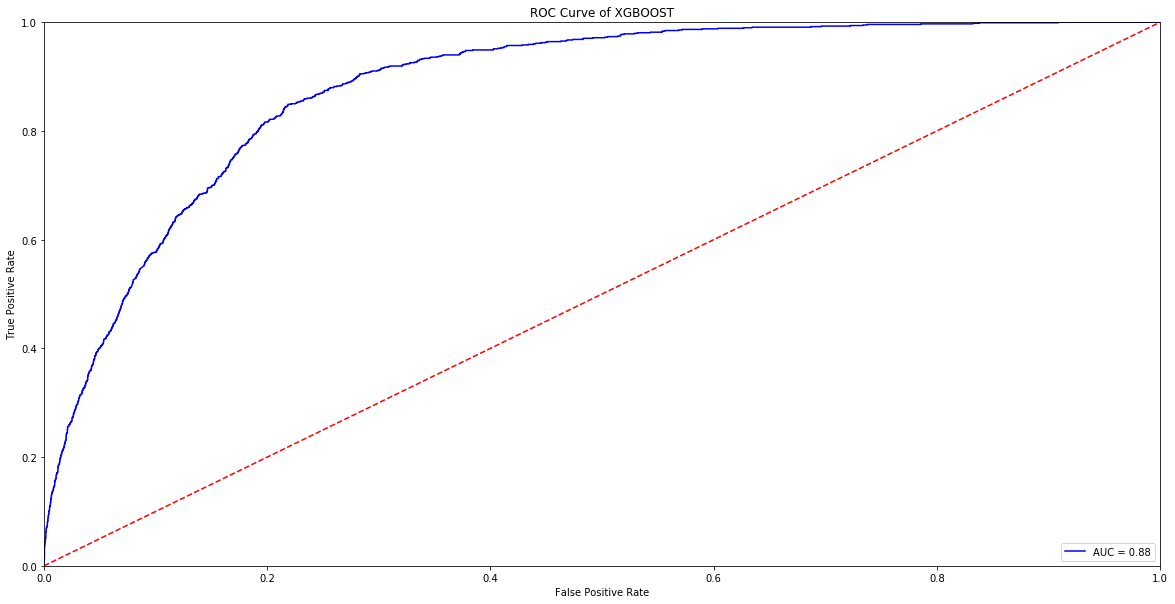

In [124]:
reduced_predictors= [x for x in reduced_features.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=400,
 max_depth=3,
 min_child_weight=30,
 gamma=0.1,
 subsample=0.6,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 reg_alpha= 0.011,
 seed=1024)
predict_test_reduced=modelfit2(xgb2, reduced_features, reduced_predictors,reduced_testSet)

In [125]:
df_test_final_std_reduced=pd.DataFrame({'person':testSet['person']})
df_test_final_std_reduced['label']=predict_test_reduced
df_test_final_std_reduced.head()

,person,label
0,00091926,0.334668
1,00091a7a,0.784894
2,000ba417,0.528305
3,000e4d9e,0.427281
4,000e619d,0.516065


In [127]:
#VERIFICAMOS PREDICCIONES FINALES STD
print np.around(df_test_final_std_reduced['label']).value_counts()
#NOS QUEDAMOS CON EL MODELO STANDARIZADO
df_test_final_std_reduced.to_csv('submit_kaggle/tuning2-features_reduced-sub_modelo3_xGBoost_9a1_std.csv', index=False)

0.0    14698
1.0     4717
Name: label, dtype: int64


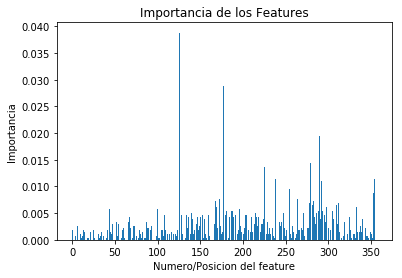

In [129]:
# plot
plt.title('Importancia de los Features')
plt.xlabel('Numero/Posicion del feature')
plt.ylabel('Importancia')
plt.bar(range(len(xgb2.feature_importances_)), xgb2.feature_importances_)
plt.show()